In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np

In [2]:
# time.sleep(30)

In [3]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines

for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "MAKWest.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com


## Set number of clusters

In [4]:
nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)


total_count = 8


nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = 2

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]




# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



2


In [5]:
clientIps, no_cluster_yet_nodes

(['127.0.0.1', '127.0.0.1'], ['127.0.0.1', '127.0.0.1', '127.0.0.1'])

## Functions

In [6]:
def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
        os.system(command)

        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ./gradlew installDist'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S rm ../dump_files/nohup*.out; echo 1234 | sudo -S rm config*/currentView;'
        
        
        os.system(command)
        
        

        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 & echo $! > ../dump_files/jobID_s'+str(i)+'.txt'
        
        print(command)
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)        
#         print(command)



def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(i-len(nodeIps)-len(no_cluster_yet_nodes))+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = ' killall java; killall nohup'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'killall java;  killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = ' nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        print(command)

# for i in range(len(lines)):
#     run_basic_client_check(i)



def join_node1(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11080 11081 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)   
        
        
def join_node2(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11090 11091 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command) 
        
def join_node3(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11100 11101 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command) 

## Compile Job

## Setup Client and nodeIPS

In [7]:
len(lines)

13

In [8]:
len(nodeIps), len(clientIps)

(8, 2)

## RUN SERVERS

In [9]:
for i in range(len(lines)):
    kill_java(i)

for i in range(len(lines)):
    clean_job(i)
    
compile_job(1)



java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no process found
nohup: no process found
java(1047582): Operation not permitted
java: no proces

> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE
> Task :jar UP-TO-DATE
> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 2s
3 actionable tasks: 3 up-to-date


In [10]:
    
for i in range(len(lines)-nclients-len(no_cluster_yet_nodes)):
    print(i)
    run_server_node(i)

0
nohup ./runscripts/startReplicaYCSB.sh 0 >../dump_files/nohup_s0.out 2>&1 & echo $! > ../dump_files/jobID_s0.txt
1
nohup ./runscripts/startReplicaYCSB.sh 1 >../dump_files/nohup_s1.out 2>&1 & echo $! > ../dump_files/jobID_s1.txt
2
nohup ./runscripts/startReplicaYCSB.sh 2 >../dump_files/nohup_s2.out 2>&1 & echo $! > ../dump_files/jobID_s2.txt
3
nohup ./runscripts/startReplicaYCSB.sh 3 >../dump_files/nohup_s3.out 2>&1 & echo $! > ../dump_files/jobID_s3.txt
4
nohup ./runscripts/startReplicaYCSB.sh 4 >../dump_files/nohup_s4.out 2>&1 & echo $! > ../dump_files/jobID_s4.txt
5
nohup ./runscripts/startReplicaYCSB.sh 5 >../dump_files/nohup_s5.out 2>&1 & echo $! > ../dump_files/jobID_s5.txt
6
nohup ./runscripts/startReplicaYCSB.sh 6 >../dump_files/nohup_s6.out 2>&1 & echo $! > ../dump_files/jobID_s6.txt
7
nohup ./runscripts/startReplicaYCSB.sh 7 >../dump_files/nohup_s7.out 2>&1 & echo $! > ../dump_files/jobID_s7.txt


In [11]:
os.system('nohup ./runscripts/startReplicaYCSB.sh '+str(8)+' >../dump_files/nohup_s'+str(8)+'.out 2>&1 &')

0

In [12]:
os.system('nohup ./runscripts/startReplicaYCSB.sh '+str(9)+' >../dump_files/nohup_s'+str(9)+'.out 2>&1 &')
os.system('nohup ./runscripts/startReplicaYCSB.sh '+str(10)+' >../dump_files/nohup_s'+str(10)+'.out 2>&1 &')


0

In [13]:
def join_node1(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 127.0.0.1 11080 11081 config0 >../dump_files/nohup_j1.out 2>&1 &"'
        
        
        os.system(command)   
        


In [14]:
lines, len(lines)

(['127.0.0.1',
  '127.0.0.1',
  '127.0.0.1',
  '127.0.0.1',
  '127.0.0.1',
  '127.0.0.1',
  '127.0.0.1',
  '127.0.0.1',
  '127.0.0.1',
  '127.0.0.1',
  '127.0.0.1',
  '127.0.0.1',
  '127.0.0.1'],
 13)

In [15]:
time.sleep(30)
!tail ../dump_files/nohup_s0.out -n 50

-- Received CID query from 2 with ID 1
-- Going to send back response to CID query with CID: -1
-- Sent CID reply to replica 2 with ID 1
-- Received CID query from 1 with ID 3
-- Going to send back response to CID query with CID: -1
-- Sent CID reply to replica 1 with ID 3
-- Received CID query from 3 with ID 1
-- Going to send back response to CID query with CID: -1
-- Sent CID reply to replica 3 with ID 1
-- Tejas: Sending CID query with ID 3 to replicas [1, 2, 3]
-- Received CID query from 2 with ID 2
-- Going to send back response to CID query with CID: -1
-- Sent CID reply to replica 2 with ID 2
-- Received CID query from 1 with ID 4
-- Going to send back response to CID query with CID: -1
-- Sent CID reply to replica 1 with ID 4
-- Received CID query from 3 with ID 2
-- Going to send back response to CID query with CID: -1
-- Sent CID reply to replica 3 with ID 2
-- Tejas: Sending CID query with ID 4 to replicas [1, 2, 3]
-- Received  CID reply from replica ( or smsg.getSender())

In [16]:


# for i in range(len(lines)):
#     kill_java(i)

In [17]:
len(nodeIps)+len(no_cluster_yet_nodes)+len(clientIps)


13

## Run basic client

In [18]:
for i in range(len(nodeIps)+len(no_cluster_yet_nodes),len(nodeIps)+len(no_cluster_yet_nodes)+len(clientIps)):
    run_basic_client(i)

In [19]:
time.sleep(40)

In [20]:
os.system('./runscripts/sm`artrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 127.0.0.1 11080 11081 config0')
os.system('./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 127.0.0.1 11090 11091 config0')
os.system('./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 10 127.0.0.1 11100 11101 config0')

sh: 1: Syntax error: EOF in backquote substitution


args.length is 5
####Tpp Service[Join]####
-- Using view stored on disk
-- ----OOOOO---- Sending message to [0, 1, 2, 3] and viewID:0
-- Sending request (RECONFIG) with reqId=0
-- Expected number of matching replies: 3
-- Receiving reply from 3 with reqId:0. Putting on pos=3
-- Receiving reply from 0 with reqId:0. Putting on pos=0
-- Receiving reply from 1 with reqId:0. Putting on pos=1
-- New view f: 1
-- addIds: [9]
-- SSL/TLS handshake complete!, Id:9  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- Reached here inside Server Connection
-- channelUnregistered
-- channelUnregistered
-- channelUnregistered
-- channelUnregistered
-- channelUnregistered
-- channelUnregistered
-- channelUnregistered
-- channelUnregistered
-- channelUnregistered
-- channelUnregistered
args.length is 5
####Tpp Service[Join]####
-- Using view stored on disk
-- ----OOOOO---- Sending message to [0, 1, 2, 3, 9] and viewID:1
-- Sending request (RECONFIG) with reqId=0
-- Expected number of matching r

0

In [21]:
time.sleep(30)

In [22]:
time.sleep(30)

In [23]:
time.sleep(80)

In [24]:

# time.sleep(30)
# run_server_node(8)
# time.sleep(15)
# join_node1(8)

# time.sleep(30)
# run_server_node(9)

# time.sleep(30)
# join_node2(9)

# time.sleep(30)
# run_server_node(10)
# time.sleep(30)
# join_node3(10)

In [25]:
# time.sleep(50)

# run_server_node(9)

# time.sleep(160)
# join_node2(9)


# for i in [2]:
#     os.system('kill -9 `cat ../dump_files/jobID_s2.txt`')
    


# time.sleep(80)



for i in range(len(lines)):
    kill_java(i)
    


java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found
java(1047582): Operation not permitted
nohup: no process found


In [26]:
# for i in range(len(lines)):
#     kill_java(i)

## Main Job

In [27]:

def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
#         print(line)
        if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())


            read_lat = '0'
            write_lat = '0'

            if ('READ AverageLatency' in line):

                print(line)

                read_lat = line.split('READ AverageLatency(us)=')[1].split(']')[0].strip()


            if ('UPDATE AverageLatency' in line):                    

                write_lat = line.split('UPDATE AverageLatency(us)=')[1].split(']')[0].strip()


            if (('READ AverageLatency' not in line) and ('UPDATE AverageLatency' not in line)):
                latencies.append(line.split('=')[1].split(']')[0].strip())
            else:
                read_frac = 0
                write_frac = 0

                if float(read_lat) > 0:
                    read_frac = 0.85

                if float(write_lat) > 0:
                    write_frac = 0.15

#                         print(line, write_frac, read_frac, float(read_lat), float(write_lat))

                lat = str( (write_frac * float(write_lat) +\
                            read_frac*float(read_lat))/(write_frac+read_frac)\
                         )
                latencies.append(lat)

            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  


In [28]:
## Byzantine Remote View Change

In [29]:
times ,thputs, lats = getTimesThputs('../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes))+'.out')
times2 ,thputs2, lats = getTimesThputs('../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes)+1)+'.out')


'../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes))+'.out'

 3 sec: 5 operations; 5 current ops/sec; [UPDATE AverageLatency(us)=252516.8] 
 252516.8 5 3
 4 sec: 17 operations; 11.96 current ops/sec; [UPDATE AverageLatency(us)=81994.33] 
 81994.33 11.96 4
 5 sec: 24 operations; 6.92 current ops/sec; [UPDATE AverageLatency(us)=140795.71] 
 140795.71 6.92 5
 6 sec: 31 operations; 6.99 current ops/sec; [UPDATE AverageLatency(us)=154901.86] 
 154901.86 6.99 6
 7 sec: 36 operations; 4.99 current ops/sec; [UPDATE AverageLatency(us)=190589] 
 190589.0 4.99 7
 8 sec: 42 operations; 5.99 current ops/sec; [UPDATE AverageLatency(us)=158152.17] 
 158152.17 5.99 8
 9 sec: 51 operations; 8.99 current ops/sec; [UPDATE AverageLatency(us)=124325.33] 
 124325.33000000002 8.99 9
 10 sec: 60 operations; 8.99 current ops/sec; [UPDATE AverageLatency(us)=96671.11] 
 96671.11 8.99 10
 11 sec: 69 operations; 8.99 current ops/sec; [UPDATE AverageLatency(us)=120672.11] 
 120672.11000000002 8.99 11
 12 sec: 88 operations; 18.98 current ops/sec; [UPDATE AverageLatency(us)=5

'../dump_files/nohup_c11.out'

In [30]:
# times - times2

In [31]:
# thputs = thputs + thputs2

In [32]:
# np.mean(lats[20:]) # 23604.83205128205

In [33]:
np.mean(lats[20:])

0.13274512607142858

In [34]:
lats

array([0.252803  , 0.08027208, 0.13915129, 0.162596  , 0.169693  ,
       0.17087217, 0.11487489, 0.10613233, 0.11889338, 0.05530145,
       0.0870656 , 0.1282955 , 0.1075026 , 0.09015536, 0.1032852 ,
       0.04457236, 0.04302565, 0.03979848, 0.03495297, 0.0319019 ,
       0.03835765, 0.02674624, 0.04380552, 0.03622648, 0.03035418,
       0.0252274 , 0.03171848, 0.03914864, 0.02946729, 0.03123578,
       0.02592308, 0.02272826, 0.04223964, 0.0206721 , 0.02444338,
       0.02344364, 0.01871031, 0.02497336, 0.03998888, 0.02388533,
       0.03003958, 0.07160114, 0.06266394, 0.04612362, 0.03756711,
       0.0310665 , 0.042888  , 2.795618  ])

In [35]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


In [36]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# # pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# # pl.title(r'Joins Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


In [37]:
times_new = [x for x in range(180)]
thputs_new = [0 for x in range(180)]
for idx, t in enumerate(times):
    thputs_new[int(t)] = thputs[idx]
    

times_new, thputs_new

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

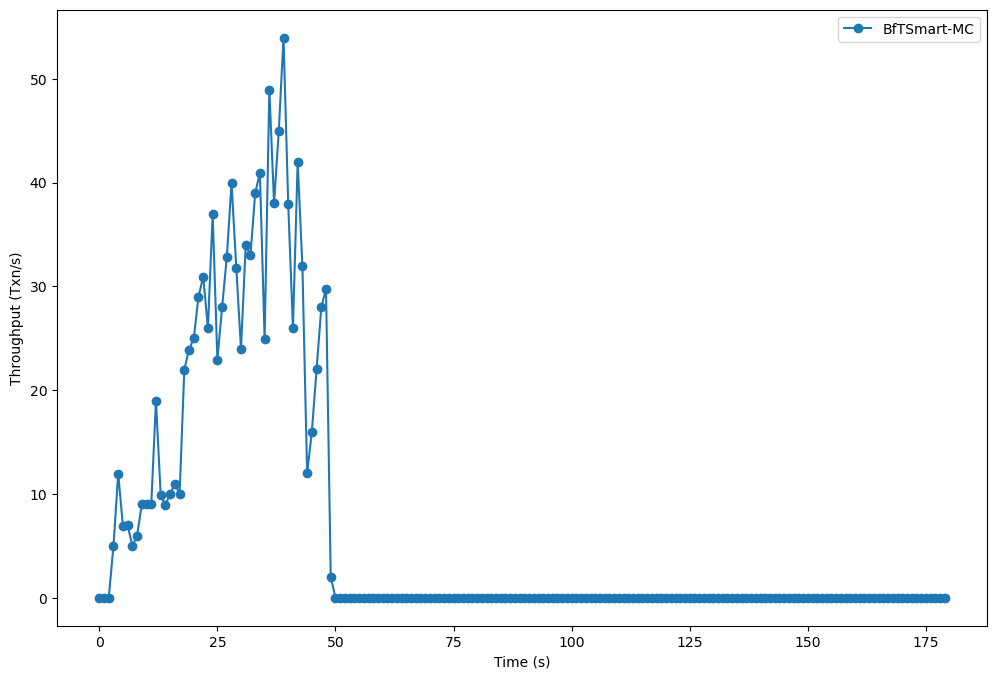

<Figure size 640x480 with 0 Axes>

In [38]:
import pylab as pl

pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
pl.plot(times_new[:], thputs_new[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
pl.show()
pl.clf()


In [39]:
(thputs), np.sum(thputs)

(array([ 5.  , 11.96,  6.92,  6.99,  4.99,  5.99,  8.99,  8.99,  8.99,
        18.98,  9.85,  8.97,  9.99, 10.99,  9.99, 21.98, 23.9 , 24.98,
        29.  , 30.94, 25.97, 36.96, 22.95, 27.97, 32.84, 39.96, 31.81,
        23.98, 33.97, 32.97, 38.96, 40.96, 24.93, 48.95, 38.  , 44.96,
        53.95, 37.89, 25.97, 41.96, 31.97, 11.99, 15.98, 22.  , 27.97,
        29.76,  2.  ]),
 1115.97)

In [40]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()
